# Integration of Motion

## Outline

[ ] Basic Euler
 - Throw a baseball
 - Compare with Truth
 - Show effect of timestep
 - Why timestep matters and error term
[ ] Verlet / Leapfrog
 - Comparison with previous baseball
 - Simple Pendulum
[ ] Runge Kutta

# Euler's Method

Starting with basic equation of motion, $ \vec{F} = m \vec{a} $

Where, using $\vec{r}$ as position, $\vec{v}$ for velocity, and $\vec{a}$ for acceleration of an object of mass $m$ experiencing the force $\vec{F}$, 
$$ \frac{d \vec{r}}{dt} = \vec{v} $$
$$  \quad \frac{d\vec{v}}{dt} = \vec{a} = \frac{1}{m} \vec{F} $$
If the force applied is only the downward force of gravity, ${F_g}_x = 0, {F_g}_y = -9.8 ~ (m / s^2)$ or more compactly $\vec{F}_g = \left[0, -9.8 \right] ~ (m / s^2)$

We can solve for the equations of motions to obtain the trajectory of a ball with initial position $\vec{r}_0$ and velocity $\vec{v}_0$ as,
$$\vec{r} (t) = \vec{r}_0 + \vec{v}_0 t - \frac{1}{2} g t^2 \hat{y}$$
Where g is the acceleration due to gravity of $(9.8 m / s^2)$.

To obtain a numerical method, we need a method for evaluating the derivatives $\frac{d\vec{r}}{dt}$ and $\frac{d\vec{v}}{dt}$ and obtain an equation of motion $\vec{r}(t)$.

Starting from the formal definition of the derivative with $\tau$ as an infitisemal time step.
$$ r'(t) = \lim_{\tau\to 0} \frac{r(t + \tau) - r(t)}{\tau} $$
This is known as the _forward derivative_, as we look _forward_ in time with a small step $\tau$.
However, for a given time $t$ and position $r(t)$, we must know the position at some small increment future time $r(t+\tau)$.
To find this new position, consider the taylor expansion of $r(t+\tau)$,
$$ r(t+\tau) = r(t) + \tau ~ r'(t) + \frac{\tau^2}{2} r''(t) + \cdots$$
The terms in the expansion involving second and higher order derivatives are equal to,
$$ \frac{\tau^2}{2} r''(t) + \cdots = \frac{\tau^2}{2} r''(\eta) $$
For some $\eta$ between $t$ and $t + \tau$.

Rearranging the taylor expansion for $r'(t)$ with this substitution, we have
$$ r'(t) = \frac{r(t + \tau) - r(t)}{\tau} - \frac{1}{2}\tau ~ r''(\eta) $$
Often written as,
$$ r'(t) = \frac{r(t + \tau) - r(t)}{\tau} + \mathcal{O}(\tau) $$
indicating that the additional term(s) are of order $\tau$ ($\tau$ raised to the one power). Rearranging for $r(t + \tau)$,
$$ r(t + \tau) = r(t) + \tau ~ r'(t) + \tau ~\mathcal{O}(\tau) $$
Since $\tau ~\mathcal{O}(\tau)$ is of order $\tau^2$, this term can be written as $\mathcal{O}(\tau^2)$, or
$$ r(t + \tau) = r(t) + \tau ~ r'(t) + \mathcal{O}(\tau^2) $$

In order to solve for $r(t + \tau)$, we must know make an approximation. In the _Euler_ method, we assume that the additional term(s) represented by $\mathcal{O}(\tau^2)$ negligible. Now solving for $r(t+\tau)$ we finally have,
$$ r(t + \tau) = r(t) + \tau ~ r'(t) $$
and for $v(t)$ we have,
$$ v(t + \tau) = v(t) + \tau ~ v'(t) $$

Substituting the values of $r'(t) = v(t)$, $v'(t) = a(t)$
$$ r(t + \tau) = r(t) + \tau ~ v(t) $$
$$ v(t + \tau) = v(t) + \tau ~ a(t) $$

Using the notation of $t_n = n ~ \tau$ and $r_{n} = r(t_n)$, $r_{n+1} = r(t_{n+1}) = r(t_n + \tau)$,
$$ r_{n+1} = r_n + \tau ~v_n $$
$$ v_{n+1} = v_n + \tau ~a_n $$
Where $a_n = a(r_n, v_n)$.
This method, based on the forward derivative, is the _Euler Method_.

Thus our method will be to 
1) Start with an initial position and velocity, $r_0$, $v_0$
2) Choose a time step $\tau$
3) Calculate $a_n = a(r_n, v_n)$
4) Use the update equations to calculate $v_{n+1}$ and $r_{n+1}$
5) Repeat steps 3 and 4 until we have reached a desired end point, either a time or some stopping condition

# Python Portion

In [130]:
import matplotlib.pyplot as plt

from dataclasses import dataclass


@dataclass
class Point2D:
    x: float = 0
    y: float = 0

    def __add__(self, other):
        temp = Point2D()
        if isinstance(other, Point2D):
            temp.x = self.x + other.x
            temp.y = self.y + other.y
            return temp
        if isinstance(other, float) or isinstance(other, int):
            temp.x = self.x + other
            temp.y = self.y + other
            return temp

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        temp = Point2D()
        if isinstance(other, Point2D):
            temp.x = self.x - other.x
            temp.y = self.y - other.y
            return temp
        if isinstance(other, float) or isinstance(other, int):
            temp.x = self.x - other
            temp.y = self.y - other
            return temp

    def __rsub__(self, other):
        return self.__sub__(other)

    def __inv__(self):
        temp = Point2D()
        temp.x = self.x * -1
        temp.y = self.y * -1
        return temp

    def __mul__(self, other):
        temp = Point2D()
        if isinstance(other, Point2D):
            temp.x = self.x * other.x
            temp.y = self.y * other.y
            return temp
        if isinstance(other, float) or isinstance(other, int):
            temp.x = self.x * other
            temp.y = self.y * other
            return temp

    def __rmul__(self, other):
        return self.__mul__(other)


@dataclass
class PointObject:
    r: Point2D
    v: Point2D
    a: Point2D


def euler_update(r, v, a, time_step):
    r_n_1 = r + time_step * v
    v_n_1 = v + time_step * a

    return r_n_1, v_n_1


@dataclass
class Ball(PointObject):
    time: float = 0

    def update(self, a, method='euler', time_step=0):
        if method == 'euler':
            self.r, self.v = euler_update(self.r, self.v, a, time_step)

            self.time += time_step


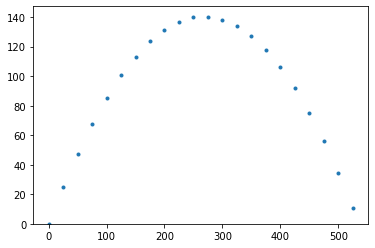

In [97]:
r_x = []
r_y = []

r_0 = Point2D(0, 0)
v_0 = Point2D(50, 50)

ball = Ball(r=r_0, v=v_0)
gravity = Point2D(0, -9.8)

while ball.r.y >= 0:
    r_x.append(ball.r.x)
    r_y.append(ball.r.y)
    
    ball.update(gravity, time_step=0.5)

plt.plot(r_x, r_y, '.')
_ = plt.ylim(0)

(0.0, 147.26250000000002)

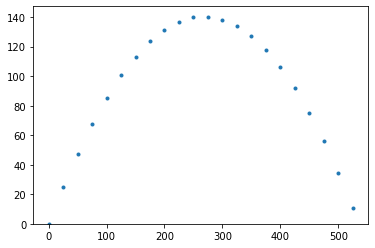

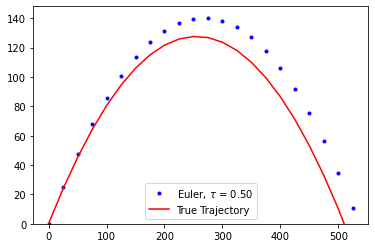

In [104]:
r_x = []
r_y = []

true_r_x = []
true_r_y = []

r_0 = Point2D(0, 0)
v_0 = Point2D(50, 50)

ball = Ball(r=r_0, v=v_0)
gravity = Point2D(0, -9.8)

tau = 0.5

while ball.r.y >= 0:
    r_x.append(ball.r.x)
    r_y.append(ball.r.y)

    true_r = r_0 + (v_0 * ball.time) + 0.5 * (ball.time ** 2) * gravity
    true_r_x.append(true_r.x)
    true_r_y.append(true_r.y)
    
    ball.update(gravity, time_step=tau)

plt.plot(r_x, r_y, 'b.', label=rf'Euler, $\tau$ = {tau:.2f}')
plt.plot(true_r_x, true_r_y, 'r-', label='True Trajectory')
plt.ylim(0)
_ = plt.legend()

We see that the Euler method is a little off compared to the expected true answer from solving the equations of motion directly. One option is to simply decrease the timestep $\tau$.

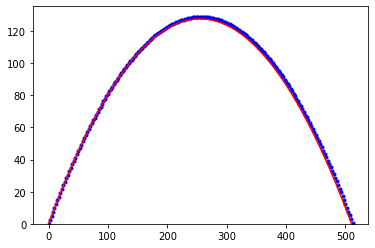

In [99]:
r_x = []
r_y = []

true_r_x = []
true_r_y = []

r_0 = Point2D(0, 0)
v_0 = Point2D(50, 50)

ball = Ball(r=r_0, v=v_0)
gravity = Point2D(0, -9.8)

while ball.r.y >= 0:
    r_x.append(ball.r.x)
    r_y.append(ball.r.y)

    true_r = r_0 + (v_0 * ball.time) + 0.5 * (ball.time ** 2) * gravity
    true_r_x.append(true_r.x)
    true_r_y.append(true_r.y)
    
    ball.update(gravity, time_step=0.05)

plt.plot(r_x, r_y, 'b.')
plt.plot(true_r_x, true_r_y, 'r-')
_ = plt.ylim(0)

## Errors

Now we see that the Euler method agrees much better with the expected trajectory. However, how do we know which $\tau$ to choose if we don't have the exact trajectory to compare it with?
In general there are three approaches: 
1. Use the expected magnitude of the error for the choose numerical algorithm (such as Euler's Method) to inform which $\tau$ will meet the desired accuracy
2. Do an iterative approach, where several methods of $\tau$ are choosen. If the trajectory stops changing significantly, $\tau$ is assumed to be small enough. That is, a smaller $\tau$ will not change the answer.
3. Use a class of algorithms which are able to choose a value of $\tau$ on their own, these are _adaptive_ methods.

In practice, most people stick with 2 in most cases if you are writing your own algorithm. And will either perform the analysis in 1 for serious work (writing a paper, doing safety analysis), or use the third approach if they are using an external library or are exceptionally motivated to write the more advanced adaptive algorithm.

For the Euler method, we can quickly do the first approach to see how this works.

In general, the accumulated error, called the _global_ error, will depend on the error introduced at each step, called the _local_ error, and the number of steps taken
$$ \text{Global Error} \propto N \times \text{Local Error}$$

In terms of the time step and the time period we are simulating, $N$ can be represented as
$$ T = N ~ \tau $$
or 
$$ N = (T / \tau) $$
The _local_ error is estimated by the dependence on $\tau$ of the additional neglected terms, which for the Euler Method is $\mathcal{O}(\tau^2)$.
Overall we have
$$ \text{Global Error} \propto (T / \tau) ~ \mathcal{O}(\tau^2) $$
or
$$ \text{Global Error} \propto T ~ \mathcal{O}(\tau^{2-1}0) = T \mathcal{O}(\tau) $$

Thus for the Euler Method, while making $\tau$ 10 times smaller will reduce the error at each step by a factor of 100, we will be taking 10 times as many steps for the same time period. And an overall reduction of the error by a factor 10. 

The previous discussion is valid for any algorithm. That is for an algorithm with local error $\mathcal{O}(\tau^n)$, the global error will be proportional to $\mathcal{O}(\tau^{n-1})$

We haven't discussed whether the local errors will always accumulate, or if they may cancel each other in every step. Studying the behavior of errors and their mangitude can be very difficult and often harder than implementing the algorithm itself!

# Euler-Cromer Method

In the Euler method, we have
$$ r_{n+1} = r_n + \tau ~v_n $$
$$ v_{n+1} = v_n + \tau ~a_n $$
Where for each new step $(n+1)$ we use the velocity of the previous step $n$.

One modification could be to instead use the newly updated $v_{n+1}$, when calculating $r_n$ as,
$$ v_{n+1} = v_n + \tau ~a_n $$
$$ r_{n+1} = r_n + \tau ~v_{n+1} $$
Where we calculate $v_{n+1}$ _first_ and use it for $r_{n+1}$. This is the _Euler-Cromer_ method illustrated below.

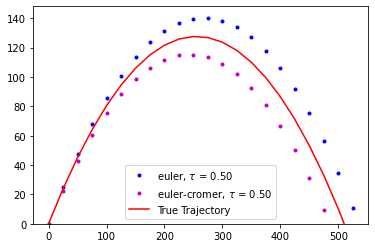

In [134]:
def euler_update(r, v, a, time_step):
    r_n_1 = r + time_step * v
    v_n_1 = v + time_step * a

    return r_n_1, v_n_1

def euler_cromer_update(r, v, a, time_step):
    v_n_1 = v + time_step * a
    r_n_1 = r + time_step * v_n_1

    return r_n_1, v_n_1

@dataclass
class Particle(PointObject):
    time: float = 0
    update_method: str = 'euler'

    def __post_init__(self):
        self.set_update_method(self.update_method)

    def set_update_method(self, method='euler'):
        self.update_method = method
        if method == 'euler':
            self._update_func = euler_update
        elif method == 'euler-cromer':
            self._update_func = euler_cromer_update

    def update(self, a, time_step=0):
        self.r, self.v = self._update_func(self.r, self.v, a, time_step)

        self.time += time_step

@dataclass
class Ball(Particle):
    def throw(self, gravity, time_step=0):
        r_x, r_y = [], []

        while self.r.y >= 0:
            r_x.append(self.r.x)
            r_y.append(self.r.y)

            self.update(gravity, time_step)
        
        return r_x, r_y


r_0 = Point2D(0, 0)
v_0 = Point2D(50, 50)

ball1 = Ball(r=r_0, v=v_0, update_method='euler')
ball2 = Ball(r=r_0, v=v_0, update_method='euler-cromer')
gravity = Point2D(0, -9.8)
tau = 0.5

ball1_r_x, ball1_r_y = ball1.throw(gravity, time_step=tau)
ball2_r_x, ball2_r_y = ball2.throw(gravity, time_step=tau)

true_trajectory = Particle(r=r_0, v=v_0)
true_r_x, true_r_y = [], []
time = 0
while true_trajectory.r.y >= 0:

    true_trajectory.r = r_0 + (v_0 * time) + 0.5 * (time ** 2) * gravity
    true_r_x.append(true_trajectory.r.x)
    true_r_y.append(true_trajectory.r.y)

    time += tau

plt.plot(ball1_r_x, ball1_r_y, 'b.', label=rf'{ball1.update_method}, $\tau$ = {tau:.2f}')
plt.plot(ball2_r_x, ball2_r_y, 'm.', label=rf'{ball2.update_method}, $\tau$ = {tau:.2f}')
plt.plot(true_r_x, true_r_y, 'r-', label='True Trajectory')
plt.ylim(0)
_ = plt.legend()

Now we see that instead of overestimating like the Euler method, the Euler-Cromer method underestimates. Perhaps we can split the difference by averaging the methods where 
$$ v_{n+1} = v_n + \tau ~a_n $$
$$ r_{n+1} = r_n + \tau ~ \frac{1}{2}(v_{n+1} + v_{n}) $$
However, instead of keep track of both $v_n$ and $v_{n+1}$ to calculate $r_{n+1}$, we can simplify by substituting the expression of $v_{n+1}$ into our new $r_{n+1}$ equation and obtain
$$ v_{n+1} = v_n + \tau ~a_n $$
$$ r_{n+1} = r_n + \tau v_n + \frac{1}{2} \tau^2 a_n $$
This is the _Midpoint Method_.

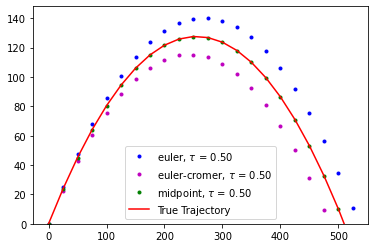

In [135]:
def euler_update(r, v, a, time_step):
    r_n_1 = r + time_step * v
    v_n_1 = v + time_step * a

    return r_n_1, v_n_1

def euler_cromer_update(r, v, a, time_step):
    v_n_1 = v + time_step * a
    r_n_1 = r + time_step * v_n_1

    return r_n_1, v_n_1

def midpoint_update(r, v, a, time_step):
    v_n_1 = v + time_step * a
    r_n_1 = r + time_step * v + 0.5 * (time_step ** 2) * a

    return r_n_1, v_n_1

@dataclass
class Particle(PointObject):
    time: float = 0
    update_method: str = 'euler'

    def __post_init__(self):
        self.set_update_method(self.update_method)

    def set_update_method(self, method='euler'):
        self.update_method = method
        if method == 'euler':
            self._update_func = euler_update
        elif method == 'euler-cromer':
            self._update_func = euler_cromer_update
        elif method == 'midpoint':
            self._update_func = midpoint_update
        

    def update(self, a, time_step=0):
        self.r, self.v = self._update_func(self.r, self.v, a, time_step)

        self.time += time_step

@dataclass
class Ball(Particle):
    def throw(self, gravity, time_step=0):
        r_x, r_y = [], []

        while self.r.y >= 0:
            r_x.append(self.r.x)
            r_y.append(self.r.y)

            self.update(gravity, time_step)
        
        return r_x, r_y


r_0 = Point2D(0, 0)
v_0 = Point2D(50, 50)

ball1 = Ball(r=r_0, v=v_0, update_method='euler')
ball2 = Ball(r=r_0, v=v_0, update_method='euler-cromer')
ball3 = Ball(r=r_0, v=v_0, update_method='midpoint')
gravity = Point2D(0, -9.8)
tau = 0.5

ball1_r_x, ball1_r_y = ball1.throw(gravity, time_step=tau)
ball2_r_x, ball2_r_y = ball2.throw(gravity, time_step=tau)
ball3_r_x, ball3_r_y = ball3.throw(gravity, time_step=tau)

true_trajectory = Particle(r=r_0, v=v_0)
true_r_x, true_r_y = [], []
time = 0
while true_trajectory.r.y >= 0:

    true_trajectory.r = r_0 + (v_0 * time) + 0.5 * (time ** 2) * gravity
    true_r_x.append(true_trajectory.r.x)
    true_r_y.append(true_trajectory.r.y)

    time += tau

plt.plot(ball1_r_x, ball1_r_y, 'b.', label=rf'{ball1.update_method}, $\tau$ = {tau:.2f}')
plt.plot(ball2_r_x, ball2_r_y, 'm.', label=rf'{ball2.update_method}, $\tau$ = {tau:.2f}')
plt.plot(ball3_r_x, ball3_r_y, 'g.', label=rf'{ball3.update_method}, $\tau$ = {tau:.2f}')
plt.plot(true_r_x, true_r_y, 'r-', label='True Trajectory')
plt.ylim(0)
_ = plt.legend()

And we see that this method is much more accurate! An error analysis of the midpoint method will show that the local error is of order $\mathcal{O}(\tau^3)$, so the global error be improved by a factor of $\tau$ compared to the Euler and Euler-Cromer methods. The advantage of using more sophisticated methods is that we require fewer timestep to obtain a result. For the simple case of simulating one ball this difference isn't important. However if we want to simulate a galaxy containing millions of stars interacting each other due to their mutual gravitational attraction, each step can potentially be very complicated and take a significant amount of time. Reducing the number of time steps will reduce the computing time required for a simulation.

In [121]:
ball.update_func

<function __main__.euler_cromer_update(r, v, a, time_step)>